In [30]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets
from torchsummary import summary
from torchvision.transforms import v2

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]


transforms = v2.Compose([
    v2.RandomCrop(size=(32,32)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.Normalize(mean = MEAN, std = STD)
    ])


test_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean = MEAN, std = STD)
])


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
cifar10_train_data = datasets.CIFAR10("/data", train= True, transform= transforms, download= True)
cifar10_train_dataloader = torch.utils.data.DataLoader(cifar10_train_data, batch_size = 16, shuffle = True)

100%|██████████| 170M/170M [00:04<00:00, 41.3MB/s]


In [6]:
cifar10_test_data = datasets.CIFAR10("/data", train=False, transform= test_transforms, download= True)
cifar10_test_dataloader = torch.utils.data.DataLoader(cifar10_test_data, batch_size=32, shuffle=False)

In [9]:
print(len(cifar10_test_data))

10000


In [10]:
print(len(cifar10_train_data))

50000


In [11]:
class_name = dict()

for i, name in enumerate(cifar10_train_data.classes):
        print(f"{name}: {i}")
        class_name[name]=i

airplane: 0
automobile: 1
bird: 2
cat: 3
deer: 4
dog: 5
frog: 6
horse: 7
ship: 8
truck: 9


In [12]:
print(len(class_name))

10


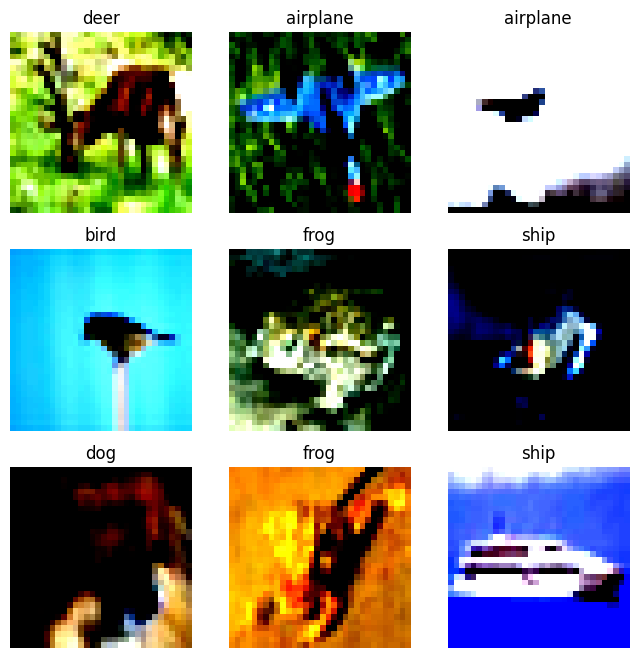

In [13]:
figure = plt.figure(figsize=(8, 8))
rows , cols = 3, 3
for index in range(rows * cols):
    sample_idx = torch.randint(len(cifar10_train_data), size=(1,)).item()
    img, label = cifar10_train_data[sample_idx]
    figure.add_subplot(rows, cols, index + 1)
    plt.title(cifar10_train_data.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [14]:
class Cifar10Classifier(torch.nn.Module):
  def __init__(self, in_channels=3):
    super(Cifar10Classifier, self).__init__()

    self.conv_block = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, 8, kernel_size=2),
        torch.nn.ReLU(),
        torch.nn.Conv2d(8, 16, kernel_size=2, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(16, 32 , kernel_size=2, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(32, 64, kernel_size=2, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(64, 128, kernel_size=2, padding=1),
        torch.nn.ReLU()
    )


    with torch.no_grad():
        dummy_input = torch.zeros(1, in_channels, 32, 32)
        flattened_size = self.conv_block(dummy_input).numel()

    self.flatten_layer = torch.nn.Flatten()

    self.clf_layer_1 = torch.nn.Linear(flattened_size, 256)
    self.clf_layer_2 = torch.nn.Linear(256, 128)
    self.clf_layer_3 = torch.nn.Linear(128, 10)

    self.dropout = torch.nn.Dropout(0.5)



  def forward (self, x):

    x = self.conv_block(x)
    x = self.flatten_layer(x)

    x = self.clf_layer_1(x)
    x = torch.nn.functional.relu(x) # Use functional API for activation
    x = self.dropout(x)
    x = self.clf_layer_2(x)
    x = torch.nn.functional.relu(x) # Use functional API for activation
    x = self.dropout(x)
    x = self.clf_layer_3(x)

    return x

In [15]:
model = Cifar10Classifier()
model = model.to(device)

In [16]:
model

Cifar10Classifier(
  (conv_block): Sequential(
    (0): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (clf_layer_1): Linear(in_features=12800, out_features=256, bias=True)
  (clf_layer_2): Linear(in_features=256, out_features=128, bias=True)
  (clf_layer_3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [17]:
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 31, 31]             104
              ReLU-2            [-1, 8, 31, 31]               0
            Conv2d-3           [-1, 16, 32, 32]             528
              ReLU-4           [-1, 16, 32, 32]               0
         MaxPool2d-5           [-1, 16, 16, 16]               0
            Conv2d-6           [-1, 32, 17, 17]           2,080
              ReLU-7           [-1, 32, 17, 17]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 9, 9]           8,256
             ReLU-10             [-1, 64, 9, 9]               0
           Conv2d-11          [-1, 128, 10, 10]          32,896
             ReLU-12          [-1, 128, 10, 10]               0
          Flatten-13                [-1, 12800]               0
           Linear-14                  [

In [21]:
criterion = torch.nn.CrossEntropyLoss()
optim= torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
n_epochs = 30
for epoch in range(n_epochs):
  model.train()

  train_loss = 0.0
  train_correct = 0
  train_total = 0
  for data, label in tqdm(cifar10_train_dataloader, desc= f"{epoch+1}/{n_epochs}"):

    data = data.to(device)
    label = label.to(device)

    optim.zero_grad()

    output = model(data)
    predicts = torch.argmax(output , 1)

    loss = criterion(output, label)
    loss.backward()
    optim.step()

    train_loss+=loss.item()
    train_correct+= (predicts==label).sum().item()
    train_total+= label.size(0)

  print(f"Epoch:{epoch+1}, Loss:{train_loss}, Train_Acc:{100 * train_correct / train_total:.2f}%")

1/30: 100%|██████████| 3125/3125 [00:33<00:00, 92.34it/s]


Epoch:1, Loss:4781.363779604435, Train_Acc:44.62%


2/30: 100%|██████████| 3125/3125 [00:34<00:00, 91.42it/s]


Epoch:2, Loss:3941.4331414699554, Train_Acc:55.78%


3/30: 100%|██████████| 3125/3125 [00:38<00:00, 80.22it/s]


Epoch:3, Loss:3446.580093204975, Train_Acc:62.01%


4/30: 100%|██████████| 3125/3125 [00:45<00:00, 68.39it/s]


Epoch:4, Loss:3138.598036915064, Train_Acc:65.68%


5/30: 100%|██████████| 3125/3125 [00:50<00:00, 61.84it/s]


Epoch:5, Loss:2920.5321486592293, Train_Acc:68.26%


6/30: 100%|██████████| 3125/3125 [00:43<00:00, 71.16it/s]


Epoch:6, Loss:2738.306752562523, Train_Acc:70.40%


7/30: 100%|██████████| 3125/3125 [00:48<00:00, 65.04it/s]


Epoch:7, Loss:2608.9779568314552, Train_Acc:71.94%


8/30: 100%|██████████| 3125/3125 [00:49<00:00, 63.69it/s]


Epoch:8, Loss:2510.464655816555, Train_Acc:73.07%


9/30: 100%|██████████| 3125/3125 [00:44<00:00, 70.57it/s]


Epoch:9, Loss:2434.8429482653737, Train_Acc:74.22%


10/30: 100%|██████████| 3125/3125 [00:43<00:00, 71.16it/s]


Epoch:10, Loss:2353.792432270944, Train_Acc:75.11%


11/30: 100%|██████████| 3125/3125 [00:54<00:00, 57.66it/s]


Epoch:11, Loss:2274.1655088216066, Train_Acc:75.83%


12/30: 100%|██████████| 3125/3125 [00:39<00:00, 79.02it/s]


Epoch:12, Loss:2221.8543474450707, Train_Acc:76.59%


13/30: 100%|██████████| 3125/3125 [00:46<00:00, 67.80it/s]


Epoch:13, Loss:2137.658639639616, Train_Acc:77.38%


14/30: 100%|██████████| 3125/3125 [00:33<00:00, 93.95it/s]


Epoch:14, Loss:2107.7155683860183, Train_Acc:77.51%


15/30: 100%|██████████| 3125/3125 [00:34<00:00, 90.39it/s]


Epoch:15, Loss:2034.730116866529, Train_Acc:78.48%


16/30: 100%|██████████| 3125/3125 [00:38<00:00, 81.00it/s]


Epoch:16, Loss:2012.4400834031403, Train_Acc:78.72%


17/30: 100%|██████████| 3125/3125 [00:33<00:00, 94.19it/s]


Epoch:17, Loss:1959.0896669253707, Train_Acc:79.17%


18/30: 100%|██████████| 3125/3125 [00:33<00:00, 94.63it/s]


Epoch:18, Loss:1903.5018401779234, Train_Acc:79.69%


19/30: 100%|██████████| 3125/3125 [00:32<00:00, 95.68it/s]


Epoch:19, Loss:1870.3683917112648, Train_Acc:80.30%


20/30: 100%|██████████| 3125/3125 [00:33<00:00, 94.57it/s]


Epoch:20, Loss:1849.3403699435294, Train_Acc:80.56%


21/30: 100%|██████████| 3125/3125 [00:33<00:00, 94.64it/s]


Epoch:21, Loss:1788.1551926136017, Train_Acc:81.19%


22/30: 100%|██████████| 3125/3125 [00:32<00:00, 94.75it/s]


Epoch:22, Loss:1761.1817222423851, Train_Acc:81.47%


23/30: 100%|██████████| 3125/3125 [00:32<00:00, 96.13it/s]


Epoch:23, Loss:1729.0629903189838, Train_Acc:82.01%


24/30: 100%|██████████| 3125/3125 [00:33<00:00, 94.15it/s]


Epoch:24, Loss:1716.9887837637216, Train_Acc:82.08%


25/30: 100%|██████████| 3125/3125 [00:33<00:00, 94.65it/s]


Epoch:25, Loss:1676.9500763881952, Train_Acc:82.31%


26/30: 100%|██████████| 3125/3125 [00:32<00:00, 95.97it/s]


Epoch:26, Loss:1638.7148018088192, Train_Acc:82.86%


27/30: 100%|██████████| 3125/3125 [00:32<00:00, 95.85it/s] 


Epoch:27, Loss:1631.1548955328763, Train_Acc:82.97%


28/30: 100%|██████████| 3125/3125 [00:33<00:00, 94.55it/s] 


Epoch:28, Loss:1599.163905205205, Train_Acc:83.30%


29/30: 100%|██████████| 3125/3125 [00:33<00:00, 94.69it/s]


Epoch:29, Loss:1589.074973281473, Train_Acc:83.50%


30/30: 100%|██████████| 3125/3125 [00:37<00:00, 84.18it/s]

Epoch:30, Loss:1548.3392513287254, Train_Acc:83.87%


In [28]:
all_labels = list()
all_preds = list()

test_total = 0
test_correct = 0

model.eval()

with torch.no_grad():
  for data, label in cifar10_test_dataloader:
    data, label = data.to(device), label.to(device)

    output = model(data)
    preds = torch.argmax(output, 1)

    test_total += label.size(0)
    test_correct += (preds == label).sum().item()

    all_labels.extend(label.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

  print(f"Acc_Test:{100*test_correct/test_total:.2f}%")







Acc_Test:75.00%


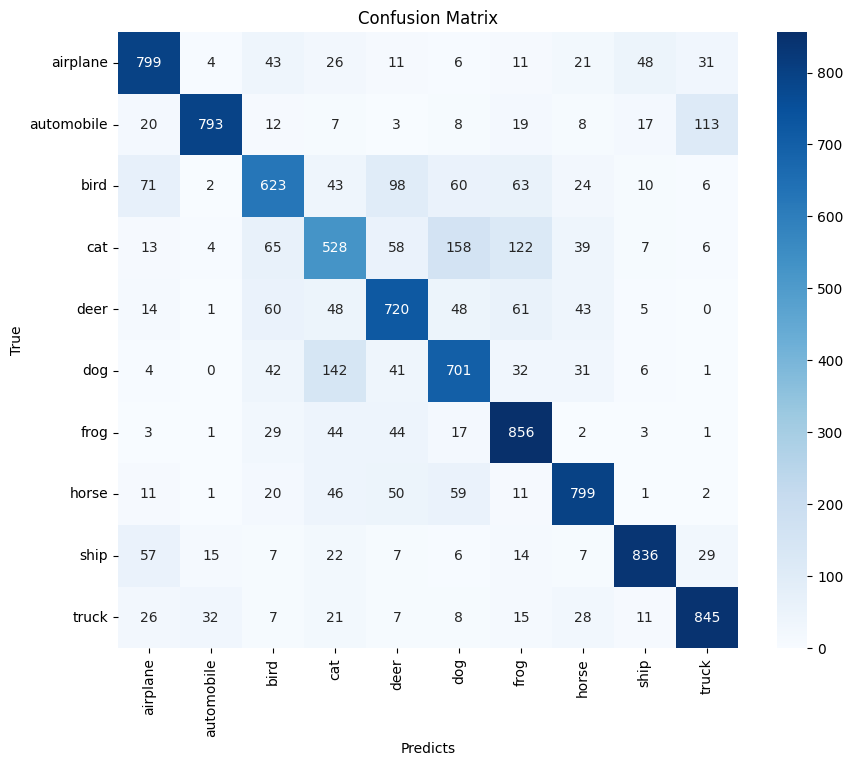

In [40]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm ,annot=True, fmt='d' ,xticklabels=class_name, yticklabels=class_name, cmap="Blues")
plt.xlabel("Predicts")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()